In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

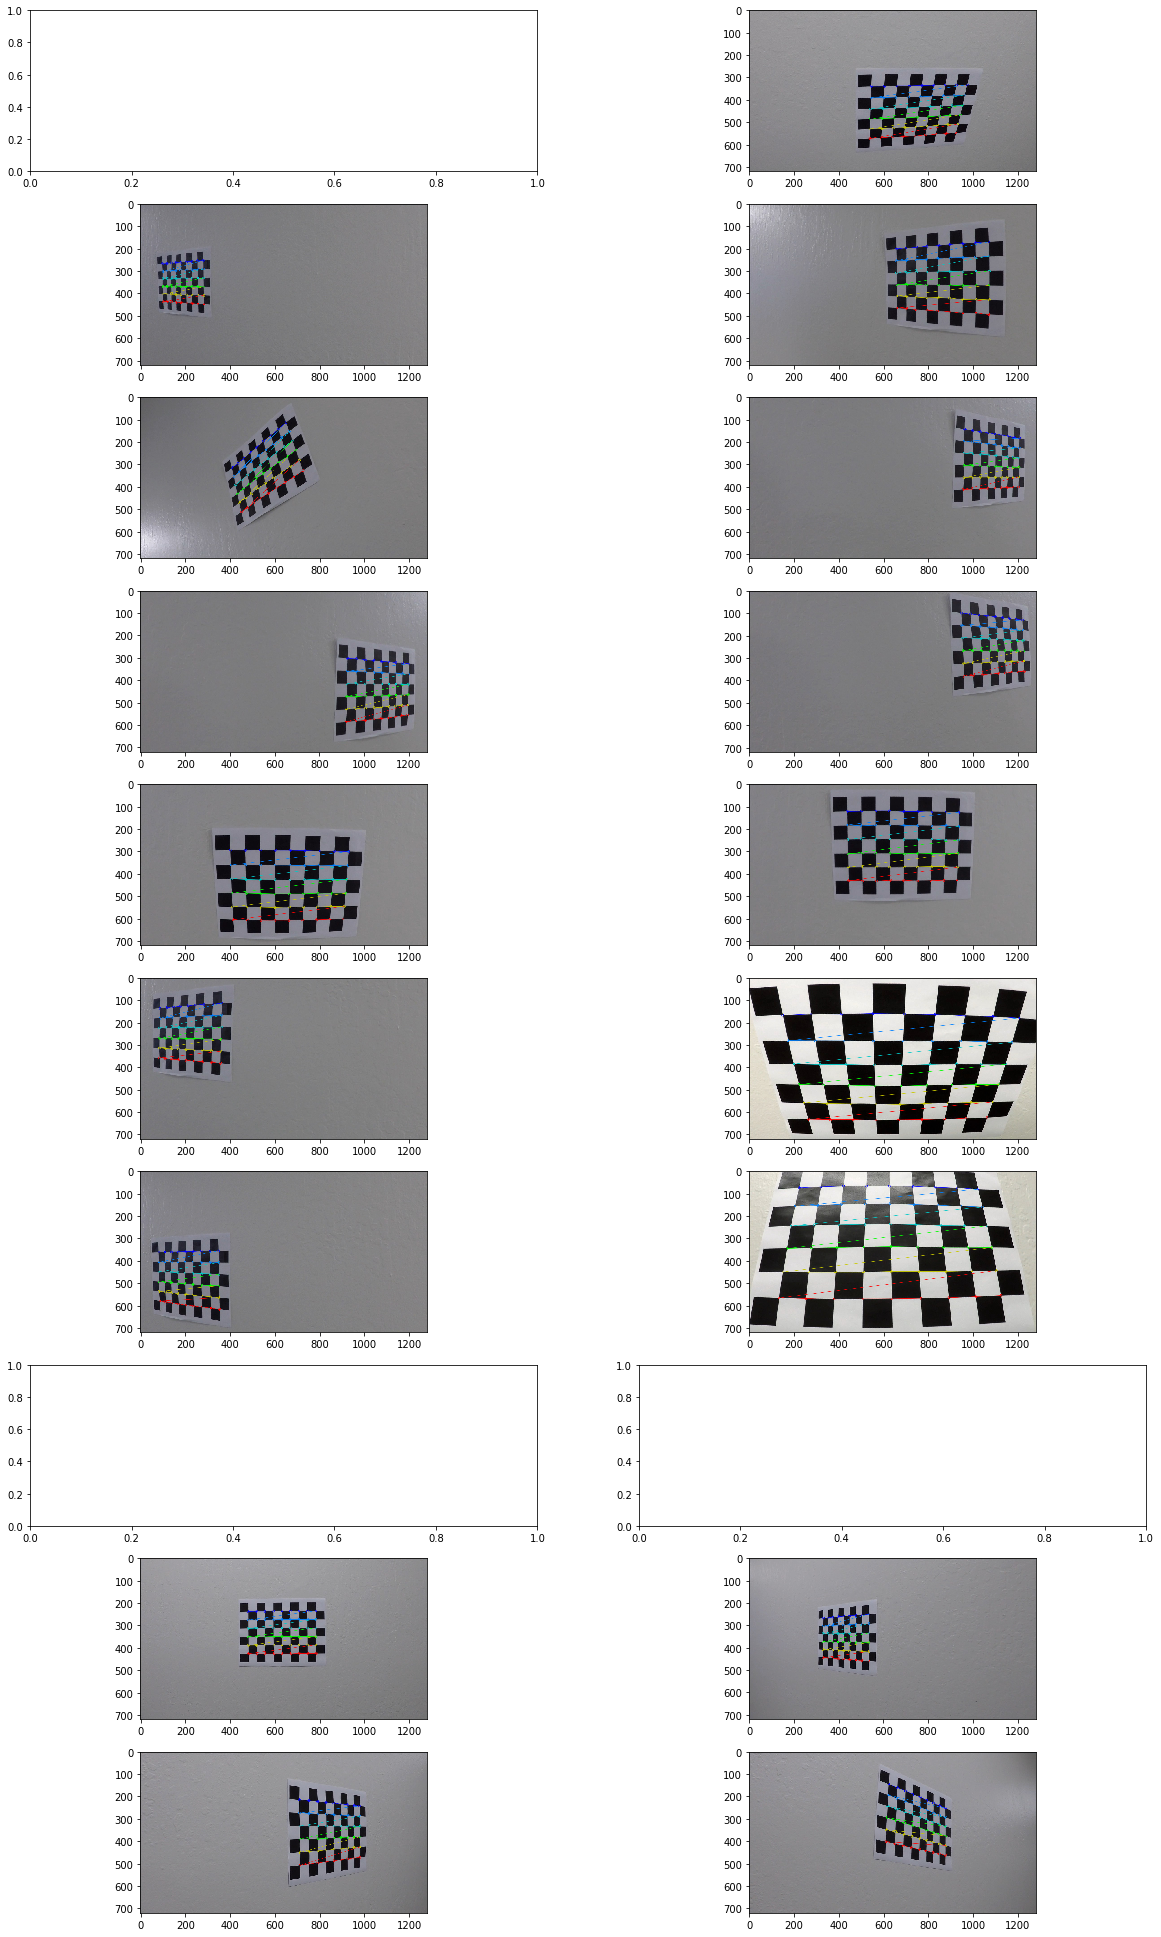

In [2]:
# Finding Corners

# Prepare object points
nx = 9
ny = 6

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points and image points from the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prep object points
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x,y coordinates

fig, ax = plt.subplots(10,2, figsize = (20, 35))
ax = ax.ravel()

# Step through each image in the calibration set
for n, fname in enumerate(images):
    # read in each image
    img = mpimg.imread(fname)
    # convert to grayscaele
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        ax[n].imshow(img)
        #cv2.imwrite("output_images/corners_" + fname, img)

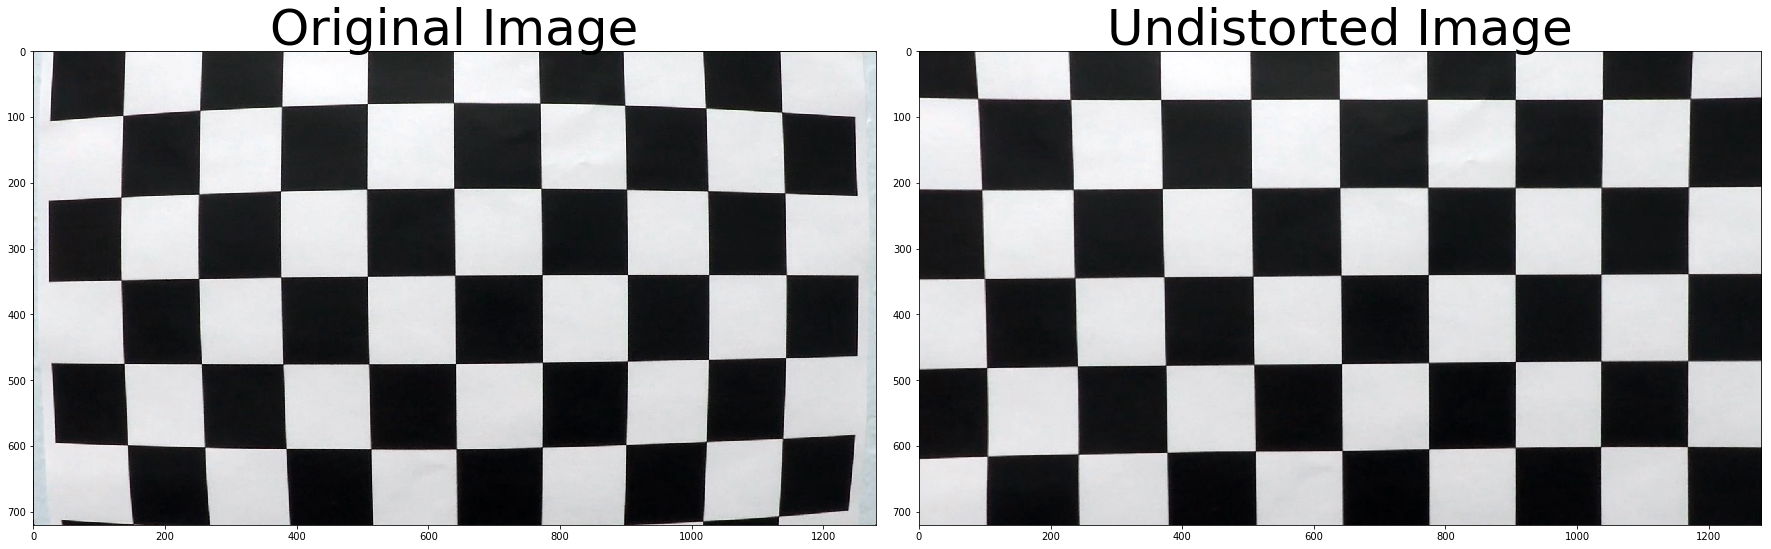

In [3]:
# Use the results obtained above to undistort an image
img = cv2.imread('./camera_cal/calibration1.jpg')

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
undistort = cv2.undistort(img, mtx, dist, None, mtx)



'''
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)
'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#cv2.imwrite("output_images/undistorted_" + fname, undistorted)

In [4]:
# Save the camera calibration result (we don't need rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_data.p", "wb" ) )

In [5]:
# load pickled distortion matrix
with open('camera_dist_data.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

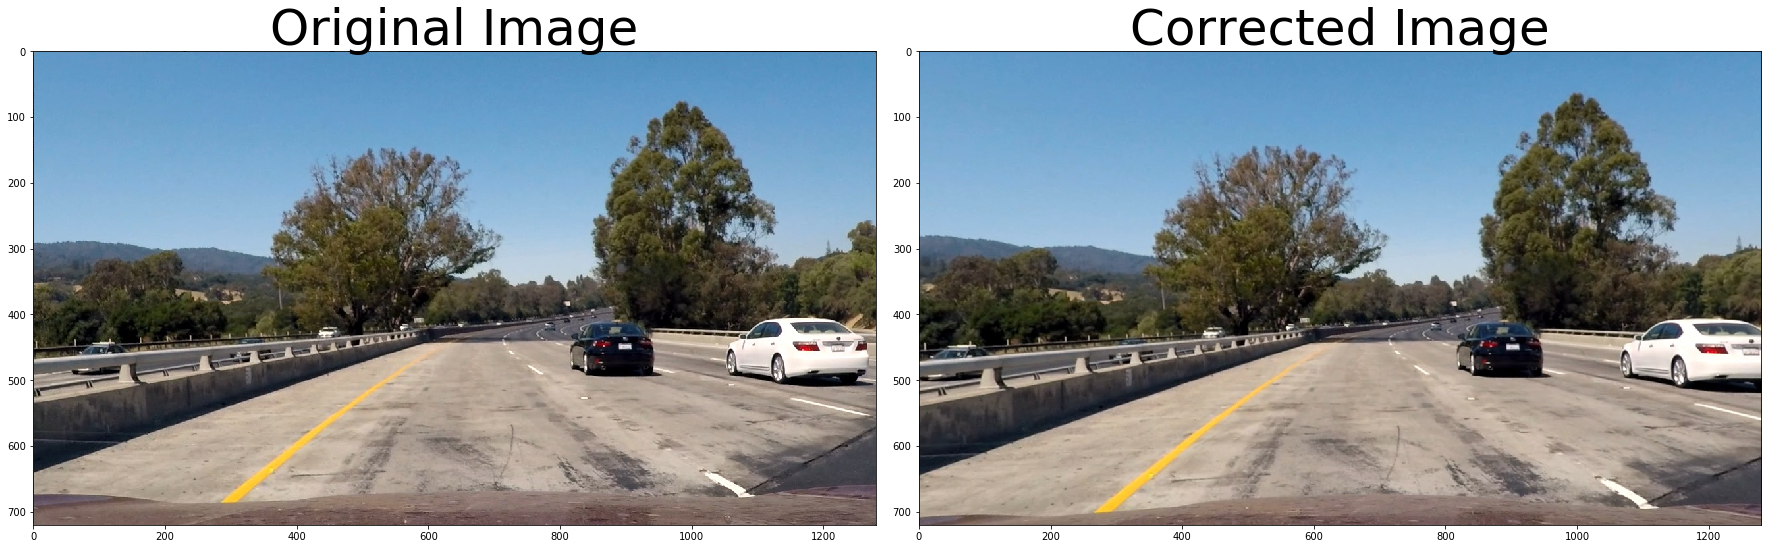

In [6]:
# Chose an image to use as an example
example = cv2.imread('./test_images/test1.jpg')
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)

# Function to correct distortion of images
def distortionCorrection(img):
    corrected = cv2.undistort(img, mtx, dist, None, mtx)
    return corrected

example_corrected = distortionCorrection(example)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(example)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(example_corrected)
ax2.set_title('Corrected Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Image Perspective Transform

In [7]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

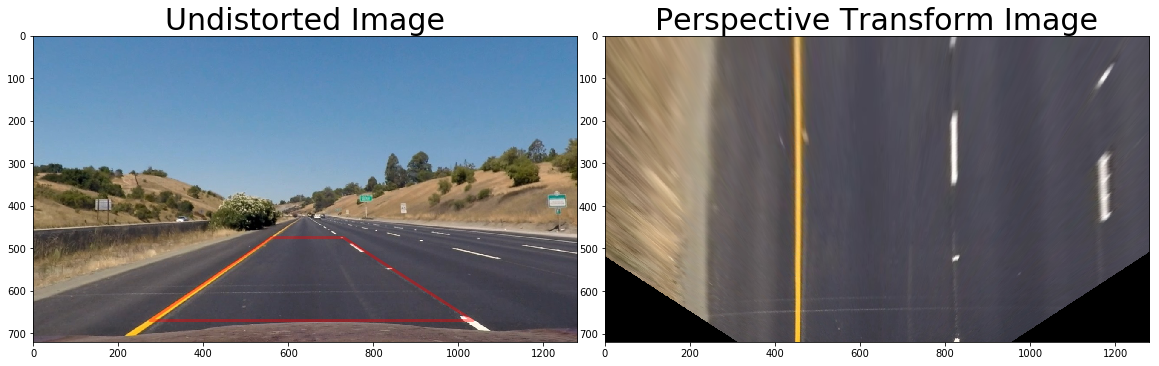

In [8]:
# Chose an image to use as an example for perspective transform
example_straight = cv2.imread('./test_images/straight_lines1.jpg')
example_straight = cv2.cvtColor(example_straight, cv2.COLOR_BGR2RGB)
example_straight_corrected = distortionCorrection(example_straight)

ex_image = example_straight_corrected

h,w = ex_image.shape[:2]

# define source and destination points for transform
src = np.float32([(560,475),
                  (730,475), 
                  (275,670), 
                  (1034,670)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

ex_image_psptfm, M, Minv = unwarp(ex_image, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(ex_image)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color= (1, 0, 0), alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(ex_image_psptfm)
ax2.set_title('Perspective Transform Image', fontsize=30)

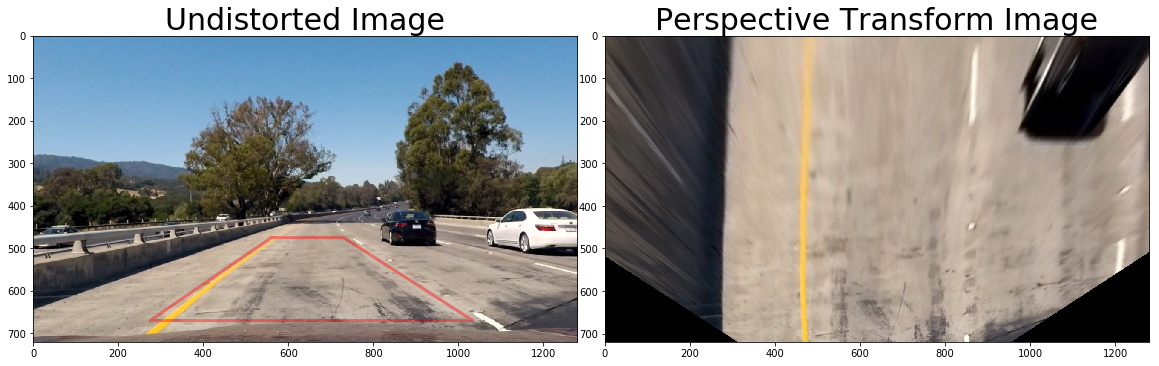

In [9]:
example_corrected_psptfm, M, Minv = unwarp(example_corrected, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(example_corrected)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color= (1, 0, 0), alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(example_corrected_psptfm)
ax2.set_title('Perspective Transform Image', fontsize=30)

In [10]:
def apply_thresh(img, thresh = (0, 255)):
    binary_out = np.zeros_like(img)
    binary_out[(img >= thresh[0])&(img <= thresh[1])] = 1
    return binary_out

def color_chan_and_thresh(img, thresh = (0, 255), color_chan = 0, color_space = None, 
                          sobel_kernel = 3, sobel_type = None, trans = 'n'):
    if color_space == 'HSV':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'HLS':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    elif color_space == 'Luv':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    elif color_space == 'Lab':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    elif color_space == 'YUV':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'gray':
        print('Gray')
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if color_space != 'gray':
        img = img[:,:,(color_chan - 1)]
        
    if sobel_type != None:
        print("Sobel")
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    if sobel_type == 'SX':
        print("Sobel X")
        img = np.absolute(sobelx)
        img = np.uint8(255*img/np.max(img))
    elif sobel_type == 'SY':
        img = np.absolute(sobely)
        img = np.uint8(255*img/np.max(img))
    elif sobel_type == 'SM':
        img = np.sqrt(sobelx**2 + sobely**2)
        img = np.uint8(255*img/np.max(img))
    elif sobel_type == 'SD':
        sobelx = np.abs(sobelx)
        sobely = np.abs(sobely)
        img = np.arctan2(sobely, sobelx)
    
    if trans == 'y':
        return img, apply_thresh(img, thresh)
    return apply_thresh(img, thresh)
        

In [ ]:
ex1 = cv2.imread('./test_images/test2.jpg')
ex1 = cv2.cvtColor(ex1, cv2.COLOR_BGR2RGB)
ex1_c = distortionCorrection(ex1)
ex1_tfm, _, _ = unwarp(ex1_c, src, dst)

test, thresh = color_chan_and_thresh(ex1_tfm, (230,255), 3, 'HSV', trans = 'y')
#test, thresh = color_chan_and_thresh(ex1_tfm, (30,100), 2, 'HLS', 3, 'SM', trans = 'y')    # Double Line
#test, thresh = color_chan_and_thresh(ex1_tfm, (30,100), 2, 'HLS', 3, 'SX', trans = 'y')    # Double Line
#test, thresh = color_chan_and_thresh(ex1_tfm, (150,255), 2, 'HLS', 3, None, trans = 'y')
#test, thresh = color_chan_and_thresh(ex1_tfm, (150,255), 3, 'HLS', 3, None, trans = 'y')    # R-Thin L-Good
#test, thresh = color_chan_and_thresh(ex1_tfm, (150,255), 0, 'gray', 3, None, trans = 'y')
#test, thresh = color_chan_and_thresh(ex1_tfm, (150,255), 3, 'RGB', 3, None, trans = 'y')    # R-Half
#test, thresh = color_chan_and_thresh(ex1_tfm, (150,255), 1, 'RGB', 3, None, trans = 'y')
fig, ax = plt.subplots(1,2, figsize = (30,20))
ax = ax.ravel()
fig.subplots_adjust(hspace = .2, wspace=.001)
ax[0].imshow(test, cmap = 'gray')
ax[0].set_title('Orig', fontsize=25)
ax[1].imshow(thresh, cmap = 'gray')
ax[1].set_title('Threshold', fontsize=25)

In [ ]:
ex2 = cv2.imread('./test_images/test1.jpg')
ex2 = cv2.cvtColor(ex2, cv2.COLOR_BGR2RGB)
ex2_c = distortionCorrection(ex2)
ex2_tfm, _, _ = unwarp(ex2_c, src, dst)

test, thresh = color_chan_and_thresh(ex2_tfm, (230,255), 3, 'HSV', trans = 'y')    # Changed Very Good
##test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SX', trans = 'y')
##test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SM', trans = 'y')    # Double Line
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 2, 'HLS', 3, None, trans = 'y')    # R-Good L-None
#test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 3, 'HLS', 3, None, trans = 'y')    # GOOD
##test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 0, 'gray', 3, None, trans = 'y')
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 3, 'RGB', 3, None, trans = 'y')    # R-Good
#test, thresh = color_chan_and_thresh(ex2_tfm, (50,120), 3, 'RGB', 3, None, trans = 'y')    # L-ok,messy - Added
#test, thresh = color_chan_and_thresh(ex2_tfm, (230,255), 1, 'RGB', 3, None, trans = 'y')    # Changed
fig, ax = plt.subplots(1,2, figsize = (30,20))
ax = ax.ravel()
fig.subplots_adjust(hspace = .2, wspace=.001)
ax[0].imshow(test, cmap = 'gray')
ax[0].set_title('Orig', fontsize=25)
ax[1].imshow(thresh, cmap = 'gray')
ax[1].set_title('Threshold', fontsize=25)

In [ ]:
ex2 = cv2.imread('./test_images/test3.jpg')
ex2 = cv2.cvtColor(ex2, cv2.COLOR_BGR2RGB)
ex2_c = distortionCorrection(ex2)
ex2_tfm, _, _ = unwarp(ex2_c, src, dst)

test, thresh = color_chan_and_thresh(ex2_tfm, (230,255), 3, 'HSV', trans = 'y')    # Changed Very Good
##test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SX', trans = 'y')
##test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SM', trans = 'y')    # Double Line
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 2, 'HLS', 3, None, trans = 'y')    # R-Good L-None
#test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 3, 'HLS', 3, None, trans = 'y')    # GOOD
##test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 0, 'gray', 3, None, trans = 'y')
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 3, 'RGB', 3, None, trans = 'y')    # R-Good
#test, thresh = color_chan_and_thresh(ex2_tfm, (50,120), 3, 'RGB', 3, None, trans = 'y')    # L-ok,messy - Added
#test, thresh = color_chan_and_thresh(ex2_tfm, (230,255), 1, 'RGB', 3, None, trans = 'y')    # Changed
fig, ax = plt.subplots(1,2, figsize = (30,20))
ax = ax.ravel()
fig.subplots_adjust(hspace = .2, wspace=.001)
ax[0].imshow(test, cmap = 'gray')
ax[0].set_title('Orig', fontsize=25)
ax[1].imshow(thresh, cmap = 'gray')
ax[1].set_title('Threshold', fontsize=25)

In [ ]:
ex2 = cv2.imread('./test_images/test4.jpg')
ex2 = cv2.cvtColor(ex2, cv2.COLOR_BGR2RGB)
ex2_c = distortionCorrection(ex2)
ex2_tfm, _, _ = unwarp(ex2_c, src, dst)

test, thresh = color_chan_and_thresh(ex2_tfm, (230,255), 3, 'HSV', trans = 'y')    # Changed Very Good
##test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SX', trans = 'y')
##test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SM', trans = 'y')    # Double Line
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 2, 'HLS', 3, None, trans = 'y')    # R-Good L-None
#test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 3, 'HLS', 3, None, trans = 'y')    # GOOD
##test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 0, 'gray', 3, None, trans = 'y')
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 3, 'RGB', 3, None, trans = 'y')    # R-Good
#test, thresh = color_chan_and_thresh(ex2_tfm, (50,120), 3, 'RGB', 3, None, trans = 'y')    # L-ok,messy - Added
#test, thresh = color_chan_and_thresh(ex2_tfm, (230,255), 1, 'RGB', 3, None, trans = 'y')    # Changed
fig, ax = plt.subplots(1,2, figsize = (30,20))
ax = ax.ravel()
fig.subplots_adjust(hspace = .2, wspace=.001)
ax[0].imshow(test, cmap = 'gray')
ax[0].set_title('Orig', fontsize=25)
ax[1].imshow(thresh, cmap = 'gray')
ax[1].set_title('Threshold', fontsize=25)

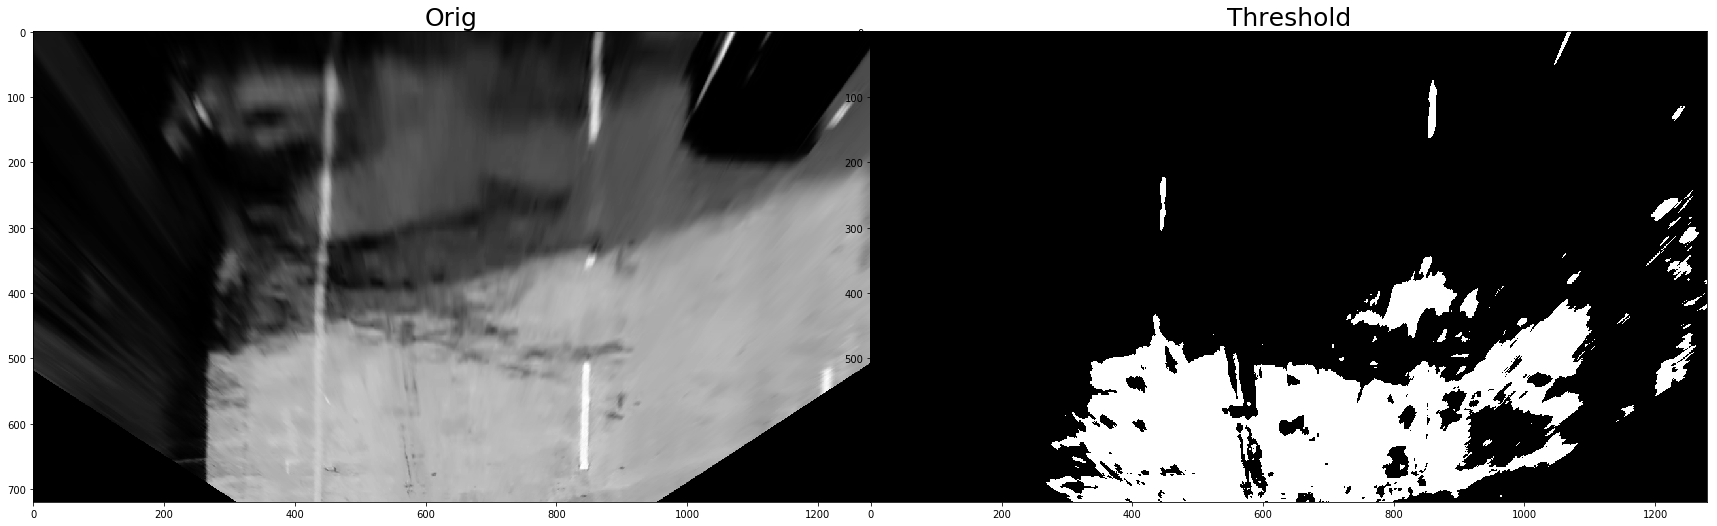

In [21]:
ex2 = cv2.imread('./test_images/test5.jpg')
ex2 = cv2.cvtColor(ex2, cv2.COLOR_BGR2RGB)
ex2_c = distortionCorrection(ex2)
ex2_tfm, _, _ = unwarp(ex2_c, src, dst)

#test, thresh = color_chan_and_thresh(ex2_tfm, (220,255), 3, 'HSV', trans = 'y')    # Changed Very Good
##test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SX', trans = 'y')
##test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SM', trans = 'y')    # Double Line
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 2, 'HLS', 3, None, trans = 'y')    # R-Good L-None
#test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 3, 'HLS', 3, None, trans = 'y')    # GOOD
##test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 0, 'gray', 3, None, trans = 'y')
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 3, 'RGB', 3, None, trans = 'y')    # R-Good
#test, thresh = color_chan_and_thresh(ex2_tfm, (50,120), 3, 'RGB', 3, None, trans = 'y')    # L-ok,messy - Added
#test, thresh = color_chan_and_thresh(ex2_tfm, (230,255), 1, 'RGB', 3, None, trans = 'y')    # Changed

fig, ax = plt.subplots(1,2, figsize = (30,20))
ax = ax.ravel()
fig.subplots_adjust(hspace = .2, wspace=.001)
ax[0].imshow(test, cmap = 'gray')
ax[0].set_title('Orig', fontsize=25)
ax[1].imshow(thresh, cmap = 'gray')
ax[1].set_title('Threshold', fontsize=25)

Gray
Sobel
Sobel X


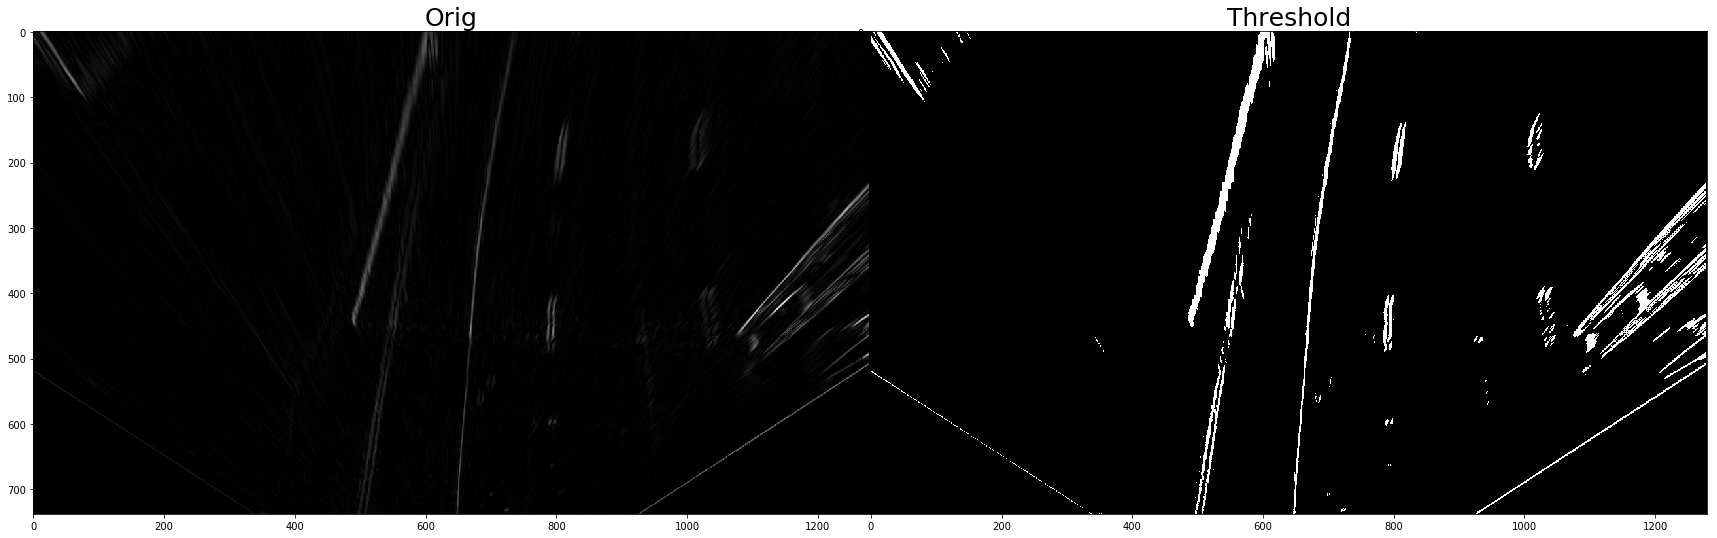

In [66]:
ex2 = cv2.imread('./test_images/test_chal3.jpg')
ex2 = cv2.cvtColor(ex2, cv2.COLOR_BGR2RGB)
ex2_c = distortionCorrection(ex2)
ex2_tfm, _, _ = unwarp(ex2_c, src, dst)

#test, thresh = color_chan_and_thresh(ex2_tfm, (220,255), 3, 'HSV', trans = 'y')    # 
test, thresh = color_chan_and_thresh(ex2_tfm, (20,700), 2, 'gray', 3, 'SX', trans = 'y')    # Good but with extras
#test, thresh = color_chan_and_thresh(ex2_tfm, (30,100), 2, 'HLS', 3, 'SM', trans = 'y')    #
#test, thresh = color_chan_and_thresh(ex2_tfm, (0,0.7), 2, 'gray', 3, 'SD', trans = 'y')
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 2, 'HLS', 3, None, trans = 'y')    # 
#test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 3, 'HLS', 3, None, trans = 'y')    # 
##test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 0, 'gray', 3, None, trans = 'y')
#test, thresh = color_chan_and_thresh(ex2_tfm, (200,255), 3, 'RGB', 3, None, trans = 'y')    # 
#test, thresh = color_chan_and_thresh(ex2_tfm, (50,120), 3, 'RGB', 3, None, trans = 'y')    # 
#test, thresh = color_chan_and_thresh(ex2_tfm, (230,255), 1, 'RGB', 3, None, trans = 'y')    # 
#test, thresh = color_chan_and_thresh(ex2_tfm, (150,255), 3, 'Luv', trans = 'y')    # OK - Left
#test, thresh = color_chan_and_thresh(ex2_tfm, (175,255), 1, 'YUV', trans = 'y')    # 
fig, ax = plt.subplots(1,2, figsize = (30,20))
ax = ax.ravel()
fig.subplots_adjust(hspace = .2, wspace=.001)
ax[0].imshow(test, cmap = 'gray')
ax[0].set_title('Orig', fontsize=25)
ax[1].imshow(thresh, cmap = 'gray')
ax[1].set_title('Threshold', fontsize=25)

In [11]:
def pipeline(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = distortionCorrection(img)
    img, M, Minv = unwarp(img, src, dst)
    
    test, thresh = color_chan_and_thresh(img, (220,255), 3, 'HSV', trans = 'y')    # Changed Very Good
    
    return thresh, Minv
    

In [67]:
def pipeline2(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = distortionCorrection(img)
    img, M, Minv = unwarp(img, src, dst)
    
    test, thresh = color_chan_and_thresh(img, (150,255), 3, 'Luv', trans = 'y')    # L - Very Good
    test2, thresh2 = color_chan_and_thresh(img, (175,255), 1, 'Luv', trans = 'y')    # R - Very Good
    
    combined = np.zeros_like(thresh2)
    combined[((thresh2 == 1)|(thresh == 1))] = 1
    
    return combined, Minv

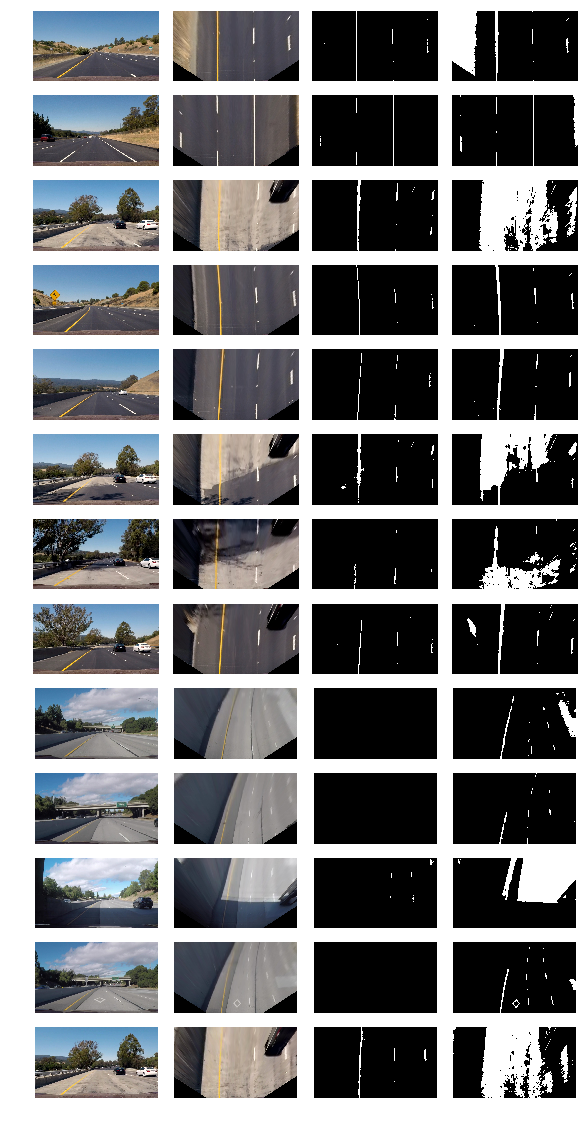

In [68]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),4, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    imge = cv2.imread(image)
    imge_t = cv2.cvtColor(imge, cv2.COLOR_BGR2RGB)
    img_persp_trans, M, Minv = unwarp(imge_t, src, dst)
    img_bin, Minv = pipeline(imge)
    img_bin2, Minv = pipeline2(imge)
    axs[i].imshow(imge_t)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_persp_trans, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin2, cmap='gray')
    axs[i].axis('off')
    i += 1